In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

from dckernel import dcmmd

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.kef as exp_kef
import experiments.efm as exp_efm
import experiments.rbm as exp_rbm

# Explore

In [6]:
# sampler
def mmd_sample_synthetic(
    key,
    m,
    n,
    d,
    c,
):
    subkeys = jax.random.split(key, num=6)
    X = jax.random.normal(subkeys[0], shape=(m, d)) / 10
    Y = jax.random.normal(subkeys[1], shape=(n, d)) / 10
    Y = Y.at[:c].set(
        jax.random.normal(subkeys[2], shape=(c, d)) / 10 + 1000
    )
    Y = jax.random.permutation(subkeys[3], Y)
    return X, Y

In [10]:
# generate data for two-sample testing
m = 100
n = 100
r = 10
d = 10
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
subkeys = jax.random.split(subkey, num=2)
X = jax.random.uniform(subkeys[0], shape=(m, d))
Y = jax.random.uniform(subkeys[1], shape=(n, d)) + 1

In [14]:
# fast
key, subkey = jax.random.split(key)
dcmmd(subkey, X, Y, r)

Array(1, dtype=int32)

In [30]:
# experiment 
experiment = 1
repetitions = 10

m = n = 100 # 2000
d = 50 # 50
r = 10

corruptions = [int(i) for i in jnp.linspace(0, m, 21)]
tests = (dcmmd,)
tests_labels = ('dcmmd',)

# run experiment
key = jax.random.PRNGKey(42)
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
for i in tqdm(range(repetitions)):
    for j in range(len(corruptions)):
        c = corruptions[j]    
        key, subkey = jax.random.split(key)
        X, Y = mmd_sample_synthetic(subkey, m, n, d, c)
        key, subkey = jax.random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs = outputs.at[t, j, i].set(
                test(
                    subkey,
                    X,
                    Y,
                    r,
                    # return_dictionary=True
                )
            )

# save results
power = jnp.mean(outputs, -1)
# jnp.save("results/mmd_synthetic_" + str(experiment) + ".npy", power)
# jnp.save("results/mmd_synthetic_" + str(experiment) + "_xaxis.npy", corruptions)

# print and plot
print(power)

  0%|          | 0/10 [00:00<?, ?it/s]

[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [28]:
print(corruptions)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [29]:
print(power)

[[0.  0.  0.  0.  0.  0.  0.1 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. ]]


In [33]:
outputs = dcmmd(
                    subkey,
                    X,
                    Y,
                    r,
                    return_dictionary=True
                )

In [37]:
outputs

(Array(1, dtype=int32),
 {'Bandwidth': Array(7.071068, dtype=float32, weak_type=True),
  'Kernel gaussian': Array(True, dtype=bool),
  'Level': Array(0.05, dtype=float32, weak_type=True),
  'MMD DC-adjusted quantile': Array(0.47985253, dtype=float32),
  'MMD V-statistic': Array(1.3999672, dtype=float32),
  'MMD quantile': Array(0.19700983, dtype=float32),
  'Number of permutations': Array(500, dtype=int32, weak_type=True),
  'Robustness': Array(10, dtype=int32, weak_type=True),
  'dcMMD test reject': Array(True, dtype=bool)})

In [36]:
outputs[1]["MMD V-statistic"]

Array(1.3999672, dtype=float32)

In [40]:
outputs[0]

Array(1, dtype=int32)

In [39]:
# assuming K = 1
alpha = 0.05
mmd_dev_threshold = np.sqrt(2 / n) * (1 + np.sqrt(- np.log(alpha)))
mmd_dev_threshold

0.38619603930539115

# Load

In [ ]:
n = 3
dim = 10
res_stats_ol = pickle.load(open(f"../data/ol/stats_n{n}_d{dim}.pkl", "rb"))
tau_res = pickle.load(open(f"../data/ol/tau_d{dim}.pkl", "rb"))

# Robust LR test

In [2]:
from jaxopt import Bisection


In [179]:
def lr_eq1(log_c, mu, eps, n):
    prob1 = null_prob(log_c, mu, n)
    prob2 = alternative_prob(log_c, mu, n)

    res = (1 - eps) * (prob1 + (1 - prob2) * jnp.exp(-log_c)) - 1
    return res

def lr_eq2(log_c, mu, eps, n):
    prob1 = null_prob(log_c, mu, n)
    prob2 = alternative_prob(log_c, mu, n)

    # print("(1-prob2)", (1-prob2))
    # print("jnp.exp(log_c) * prob1", jnp.exp(log_c) * prob1)
    # print("eps", eps)
    res = (1 - eps) * ((1-prob2) + jnp.exp(log_c) * prob1) - 1
    return res

def null_prob(log_gamma, mu, n):
    x0 = (log_gamma / n + mu**2/2.) / mu
    arg1 = x0 * jnp.sqrt(n) / jnp.sqrt(2)
    prob1 = jnp.where(
        arg1 >= 0.,
        0.5 + 0.5 * jax.scipy.special.erf(arg1),
        0.5 - 0.5 * jax.scipy.special.erf(-arg1)
    )
    return prob1

def alternative_prob(log_gamma, mu, n):
    x0 = (log_gamma / n + mu**2/2.) / mu
    arg2 = (x0 - mu) * jnp.sqrt(n) / jnp.sqrt(2)
    prob2 = jnp.where(
        arg2 >= 0,
        0.5 + 0.5 * jax.scipy.special.erf(arg2),
        0.5 - 0.5 * jax.scipy.special.erf(-arg2)
    )
    return prob2

def find_decision_threshold(mu, alpha, n, lb=-1e3, ub=1e3):
    fn = lambda lg: null_prob(lg, mu, n) - (1-alpha)
    bisec = Bisection(optimality_fun=fn, lower=lb, upper=ub)
    lg = bisec.run().params
    return lg

def lr(xs, mu):
    """
    xs: (..., n)
    """
    n = xs.shape[-1]
    xs_mean = jnp.mean(xs, -1)
    return jnp.exp(-0.5 * n * mu**2 + n * xs_mean * mu)

def log_lr_fn(xs, mu):
    log_lr = jnp.sum(
        jax.scipy.stats.norm.logpdf(xs, loc=mu) - jax.scipy.stats.norm.logpdf(xs),
        -1,
    )
    return log_lr

def trunc_log_lr_fn(xs, mu, log_c1, log_c2):
    """c2 <= c1
    """
    assert log_c2 <= log_c1
    log_lr = log_lr_fn(xs, mu)
    log_lr = jnp.where(log_lr > log_c1, log_c1, log_lr)
    log_lr = jnp.where(log_lr < log_c2, log_c2, log_lr)
    return log_lr

def null_prob_trunc(log_gamma, mu, n, log_c1, log_c2, eps):
    # res = jnp.where(jnp.allclose(log_gamma, log_c2), null_prob(log_c2, mu, n), 0.)
    # res = jnp.where(
    #     jnp.logical_and(log_c2 < log_gamma, log_gamma < log_c1),
    #     null_prob(log_gamma, mu, n),
    #     res,
    # )
    # # print("res", res)
    # res = jnp.where(log_c1 <= log_gamma, 1., res)
    # # print("res", res)
    # return res

    res = jnp.where(jnp.allclose(log_gamma, log_c2), (1-eps) * null_prob(log_c2, mu, n), 0.)
    # print("res", res)
    res = jnp.where(
        jnp.logical_and(log_c2 < log_gamma, log_gamma < log_c1),
        (1-eps) * null_prob(log_gamma, mu, n),
        res,
    )
    # print("res", res)
    res = jnp.where(log_gamma >= log_c1, 1., res)
    # print("res", res)
    return res

def find_log_decision_threshold_trunc(mu, alpha, n, log_c1, log_c2, eps, lb=-100, ub=100):
    fn = lambda lg: null_prob_trunc(lg, mu, n, log_c1, log_c2, eps) - (1-alpha)
    bisec = Bisection(optimality_fun=fn, lower=lb, upper=ub)
    lg = bisec.run().params
    return lg

def find_log_decision_threshold_trunc_boot(alpha, n, mean_data, mu, log_c1, log_c2, nboot=1000):
    Xs = np.random.multivariate_normal(mean_data, np.eye(1), (nrep, n)) # nrep, n, 1
    Xs = jnp.squeeze(Xs, -1) # nrep, n
    trunc_log_lr = trunc_log_lr_fn(Xs, mu, log_c1, log_c2) # nrep
    quantile = jnp.percentile(trunc_log_lr, 100 * (1-alpha))
    return quantile

In [139]:
mu = 1.
eps = 0.05

bisec1 = Bisection(optimality_fun=lr_eq1, lower=0, upper=10.)
c1 = bisec1.run(mu=mu, eps=eps, n=1).params
bisec2 = Bisection(optimality_fun=lr_eq2, lower=0, upper=10.)
c2 = bisec2.run(mu=mu, eps=eps, n=1).params

print(c1, c2)

1.7098999 0.7196617


In [140]:
c_ls = np.linspace(0., 5., 1000)
rr = [lr_eq2(c, mu=1., eps=0.05, n=1) for c in c_ls]

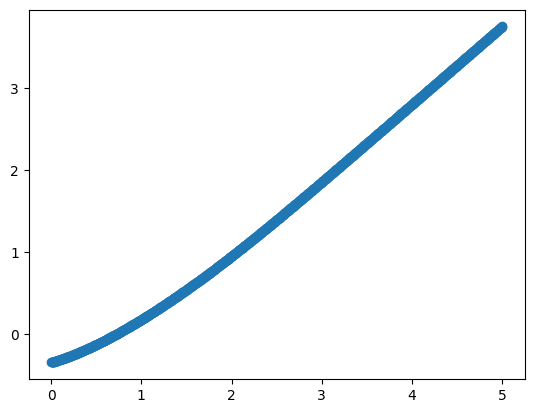

In [141]:
plt.scatter(c_ls, rr)
# plt.yscale("log")

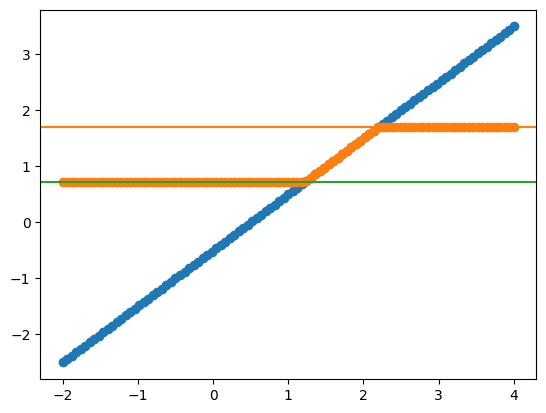

In [152]:
x_ls = np.linspace(-2., 4., 101)
log_lr_ls = log_lr_fn(x_ls.reshape((-1, 1)), mu)
trunc_log_lr_ls = trunc_log_lr_fn(x_ls.reshape((-1, 1)), mu, c1, c2)

plt.scatter(x_ls, log_lr_ls)
plt.scatter(x_ls, trunc_log_lr_ls)
plt.axhline(c1, color="C1", label="c1")
plt.axhline(c2, color="C2", label="c2")
plt.show()

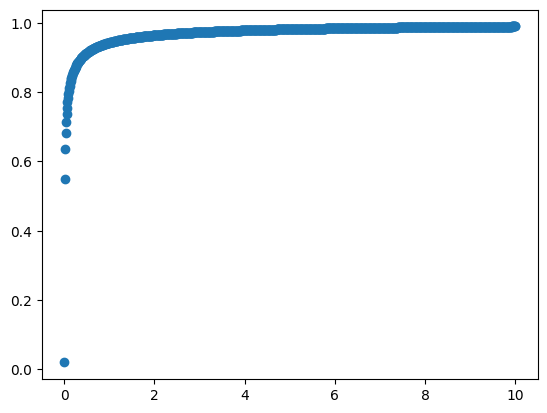

In [12]:
x_ls = np.linspace(1e-5, 10., 1001)
null_prob_ls = null_prob(x_ls, mu, n=10)
plt.scatter(x_ls, null_prob_ls)

In [13]:
null_prob_ls

Array([0.01971996, 0.54980624, 0.6346544 , ..., 0.9895184 , 0.9895272 ,
       0.9895359 ], dtype=float32)

In [15]:
gamma = find_decision_threshold(mu, alpha=0.05, n=10)
gamma

Array(1.2231534, dtype=float32)

In [180]:
def robust_LR_experiment(nrep, n, ol, eps, eps0, mu=1., dim=1):
    mean_data = np.zeros((dim,)) # data
    Xs = np.random.multivariate_normal(mean_data, np.eye(dim), (nrep, n)) # nrep, n, 1
    ol_mean = np.ones(dim)[:1] * ol
    Xs = jax.vmap(lambda x: exp_efm.sample_outlier_contam(x, eps=eps, ol_mean=ol_mean, ol_std=0.1))(Xs)
    Xs = jnp.reshape(Xs, (nrep, n)) # nrep, n

    # 1. LR
    # compute LR
    log_lr_vals = log_lr_fn(Xs, mu)

    # compute decision threshold
    log_threshold = find_decision_threshold(mu, alpha=0.05, n=n)

    # compute decision
    rej = jnp.astype(log_lr_vals > log_threshold, jnp.int32)

    # 2. robust LR
    # compute truncated LR
    bisec1 = Bisection(optimality_fun=lr_eq1, lower=-10, upper=10)
    log_c1 = bisec1.run(mu=mu, eps=eps0, n=n).params
    
    bisec2 = Bisection(optimality_fun=lr_eq2, lower=-10, upper=5)
    log_c2 = bisec2.run(mu=mu, eps=eps0, n=n).params
    trunc_log_lr_vals = trunc_log_lr_fn(Xs, mu, log_c1, log_c2)

    # compute decision threshold
    log_threshold_trunc = find_log_decision_threshold_trunc(
        mu, alpha=0.05, n=n, log_c1=log_c1, log_c2=log_c2, eps=eps0,
    )
    # log_threshold_trunc = find_log_decision_threshold_trunc_boot(0.05, n, mean_data, mu, log_c1, log_c2)

    # compute decision
    print("log_c1", log_c1, "log_c2", log_c2)
    print("trunc_log_lr_vals", trunc_log_lr_vals)
    print("log_threshold_trunc", log_threshold_trunc)
    rej_trunc = jnp.astype(trunc_log_lr_vals > log_threshold_trunc, jnp.int32)
    
    return rej, rej_trunc

In [158]:
np.random.seed(1)
lr_rej, lr_rej_trunc = robust_LR_experiment(nrep=1000, n=100, ol=10., eps=0.05, eps0=0.05, mu=1.)

log_c1 2.944336 log_c2 -2.9444885
trunc_log_lr_vals [ 2.944336    2.944336   -1.2840443  -0.53993416  2.944336    2.944336
 -2.9444885  -2.9444885   2.944336    2.944336    1.1100197  -2.9444885
  2.944336    2.944336    2.944336   -2.9444885  -1.6177254   2.944336
  2.2096605  -2.9444885  -2.9444885   2.777132    2.944336   -2.9444885
  2.944336   -2.9444885   2.944336    2.247984   -1.9613285  -2.9444885
  2.944336    2.944336   -2.9444885  -2.9444885  -2.9444885  -2.9444885
  2.944336   -1.8316851  -0.34803772  2.944336    2.944336    2.944336
  2.944336   -2.9444885   2.944336    2.944336    2.944336    2.944336
  2.944336    2.944336   -2.9444885   0.4229536  -2.9444885   2.944336
 -2.9444885   2.944336   -2.9444885   0.45741463 -2.9444885  -2.9444885
  2.944336   -2.9444885   2.944336    2.944336   -2.792986   -0.6796837
  2.563879   -2.9444885  -2.9444885  -2.9444885  -2.9444885  -2.9444885
 -2.609314   -2.9444885   2.944336   -2.9444885  -2.9444885   2.944336
  1.674078    2.94

In [159]:
jnp.mean(lr_rej), jnp.mean(lr_rej_trunc)

(Array(1., dtype=float32), Array(0.52900004, dtype=float32))

In [160]:
dim = 1
n = 100
nrep = 1000
mu = 1.

np.random.seed(1)

mean_data = np.zeros((dim,)) # data
Xs = np.random.multivariate_normal(mean_data, np.eye(dim), (nrep, n)) # nrep, n, 1
Xs = jnp.reshape(Xs, (nrep, n)) # nrep, n

# compute LR
log_lr_vals = log_lr_fn(Xs, mu) # nrep

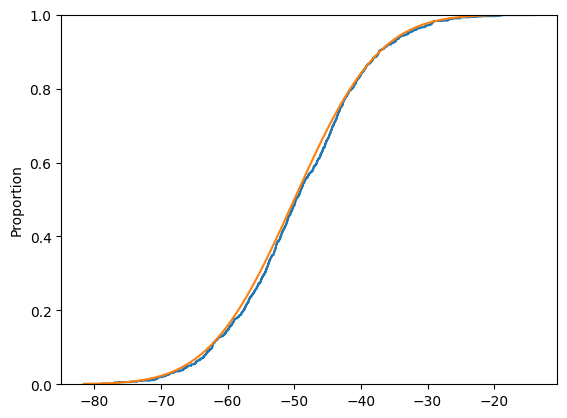

In [161]:
threshold = find_decision_threshold(mu, alpha=0.05, n=n)

x_ls = jnp.linspace(jnp.min(log_lr_vals), jnp.max(log_lr_vals), 1001)
p0_vals = jax.vmap(lambda x: null_prob(x, mu, n))(x_ls)

sns.ecdfplot(log_lr_vals)
plt.plot(x_ls, p0_vals, color="C1")
# plt.axhline(0.95, color="grey")
# plt.axvline(threshold, color="grey")

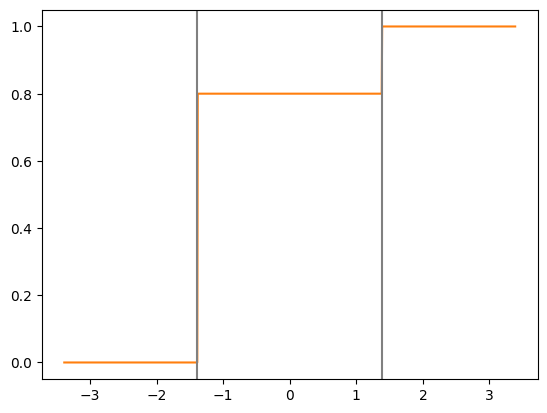

In [182]:
eps = 0.2

bisec1 = Bisection(optimality_fun=lr_eq1, lower=-10, upper=10.)
log_c1 = bisec1.run(mu=mu, eps=eps, n=n).params
bisec2 = Bisection(optimality_fun=lr_eq2, lower=-10, upper=5.)
log_c2 = bisec2.run(mu=mu, eps=eps, n=n).params
trunc_log_lr_vals = trunc_log_lr_fn(Xs, mu, log_c1, log_c2)

x_ls = jnp.linspace(log_c2 - 2., log_c1 + 2., 1001)
trunc_probs_theo = null_prob_trunc(x_ls, mu, n, log_c1, log_c2, eps)

# compute decision threshold
log_threshold_trunc = find_log_decision_threshold_trunc(
    mu, alpha=0.05, n=n, log_c1=log_c1, log_c2=log_c2, eps=eps,
)

# sns.ecdfplot(trunc_log_lr_vals)
plt.plot(x_ls, trunc_probs_theo, color="C1")
# plt.plot(x_ls, p0_vals, color="C2")
plt.axvline(log_c1, color="grey")
plt.axvline(log_c2, color="grey")

In [178]:
null_prob(x_ls, mu, n)

arg1 [4.830687  4.8645496 4.898412  4.932275  4.9661374 5.        5.0338626
 5.067725  5.101588  5.135451  5.169313 ]


Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [173]:
lr_eq1(log_c1, mu=mu, eps=eps, n=n)

Array(6.556511e-06, dtype=float32)

In [168]:
log_c1, log_c2, log_threshold_trunc

(Array(1.386261, dtype=float32),
 Array(-1.386261, dtype=float32),
 Array(1.3862607, dtype=float32))

In [92]:
np.mean(trunc_log_lr_vals > log_threshold_trunc)

Array(0.054, dtype=float32)

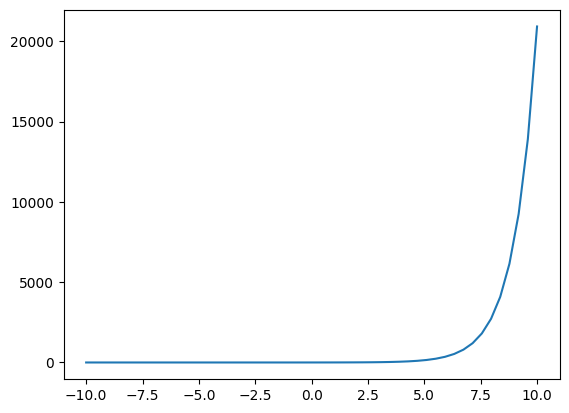

In [274]:
lg = jnp.linspace(-10, 10)
eq2_vals = lr_eq2(lg, mu=mu, eps=eps, n=n)

plt.plot(lg, eq2_vals)

In [275]:
eq2_vals

Array([-4.9957991e-02, -4.9936593e-02, -4.9904346e-02, -4.9855709e-02,
       -4.9782455e-02, -4.9672246e-02, -4.9506128e-02, -4.9255967e-02,
       -4.8879504e-02, -4.8312724e-02, -4.7459722e-02, -4.6175838e-02,
       -4.4243932e-02, -4.1336834e-02, -3.6963046e-02, -3.0382395e-02,
       -2.0482183e-02, -5.5882335e-03,  1.6816974e-02,  5.0521016e-02,
        1.0122013e-01,  1.7748260e-01,  2.9219520e-01,  4.6474195e-01,
        7.2427678e-01,  1.1146505e+00,  1.7018151e+00,  2.5849714e+00,
        3.9133196e+00,  5.9112668e+00,  8.9163399e+00,  1.3436189e+01,
        2.0234350e+01,  3.0459229e+01,  4.5838104e+01,  6.8968880e+01,
        1.0375892e+02,  1.5608511e+02,  2.3478665e+02,  3.5315814e+02,
        5.3119586e+02,  7.9897388e+02,  1.2017263e+03,  1.8074874e+03,
        2.7185854e+03,  4.0889229e+03,  6.1499844e+03,  9.2499385e+03,
        1.3912425e+04,  2.0925066e+04], dtype=float32)

# Lq-Likelihood-Ratio-Type Test

In [183]:
import lqrt

In [200]:
def robust_Lq_experiment(nrep, n, ol, eps, mu=1., dim=1):
    Xs = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), (nrep, n)) # nrep, n, 1
    ol_mean = np.ones(dim)[:1] * ol
    Xs = jax.vmap(lambda x: exp_efm.sample_outlier_contam(x, eps=eps, ol_mean=ol_mean, ol_std=0.1))(Xs)
    Xs = jnp.reshape(Xs, (nrep, n)) # nrep, n

    # Lq test
    pvals = []
    for x in tqdm(Xs):
        pvals.append(lqrt.lqrtest_1samp(x, 0.)[1])
    
    return pvals

In [206]:
nrep = 100
n = 500
ol = 10.
eps_ls = [0., 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.]

res = {}
for eps in eps_ls:
    res[eps] = jnp.array(robust_Lq_experiment(nrep, n, ol, eps, mu=1.))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

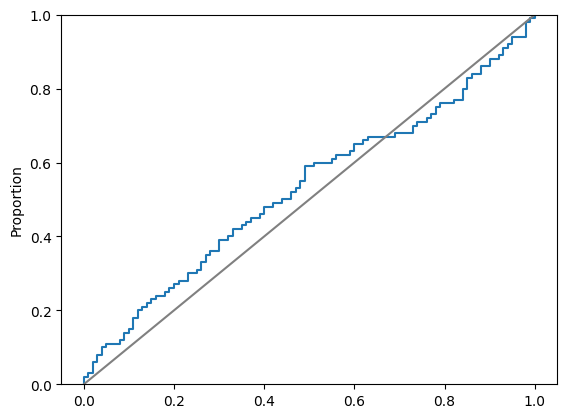

In [216]:
sns.ecdfplot(res[0.])
plt.plot([0., 1.], [0., 1.], color="grey")

(-0.01, 1.01)

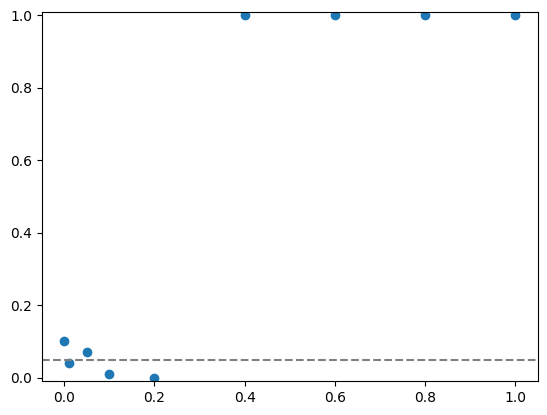

In [211]:
rej_probs = [jnp.mean(res[e] < 0.05) for e in eps_ls]
plt.scatter(eps_ls, rej_probs)
plt.axhline(0.05, color="grey", linestyle="--")
plt.ylim(-0.01, 1.01)

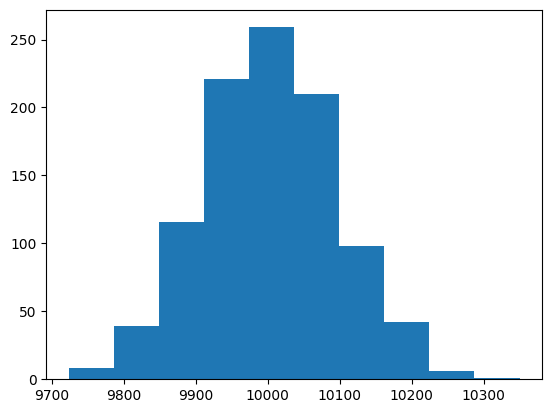

In [224]:
xi = np.random.binomial(n=100000, p=0.1, size=1000)
_ = plt.hist(xi)